In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.optim.lr_scheduler as lr_scheduler
from utils import mnist, plot_graphs, plot_mnist
import numpy as np
from torch.nn import Parameter
import math
import time

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

 load data and transform

In [3]:
train_loader, test_loader = mnist(batch_size= 100 , shuffle=False)

In [4]:
print('train len ={}'.format(len(train_loader.sampler)))
print('test len ={}'.format(len(test_loader.sampler)))

train len =60000
test len =10000


create Net

In [5]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU()):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding))
        if pool_layer is not None:
            layers.append(pool_layer)
        if activation_fn:
            layers.append(activation_fn)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [29]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
                
        self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)
        self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
        self.fc = FullyConnected([32*7*7, 10], dropout=dropout)
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
    
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        return x
        
    def forward(self, x , target):
        x = self.conv(x)
        x = x.view(-1, 32*7*7)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [30]:
class Arcface_loss(nn.Module):
    def __init__(self, num_classes, feat_dim, device, s=8, m=0.2):
        super(Arcface_loss, self).__init__()
        self.feat_dim = feat_dim
        self.num_classes = num_classes
        self.s = s
        self.m = m
        self.weights = nn.Parameter(torch.randn(num_classes, feat_dim))
        self.device = device

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.mm = math.sin(math.pi-m)*m
        self.threshold = math.cos(math.pi-m)

    def forward(self, feat, label):
        eps = 1e-4
        batch_size = feat.shape[0]
        norms = torch.norm(feat, p=2, dim=-1, keepdim=True)
        feat_l2norm = torch.div(feat, norms)
        feat_l2norm = feat_l2norm * self.s

        norms_w = torch.norm(self.weights, p=2, dim=-1, keepdim=True)
        weights_l2norm = torch.div(self.weights, norms_w)

        fc7 = torch.matmul(feat_l2norm, torch.transpose(weights_l2norm, 0, 1))

        if torch.cuda.is_available():
            label = label.cuda()
            fc7 = fc7.cuda()
        else:
            label = label.cpu()
            fc7 = fc7.cpu()

        target_one_hot = torch.zeros(len(label), self.num_classes).to(self.device)
        target_one_hot = target_one_hot.scatter_(1, label.unsqueeze(1), 1.)        
        zy = torch.addcmul(torch.zeros(fc7.size()).to(self.device), 1., fc7, target_one_hot)
        zy = zy.sum(-1)

        cos_theta = zy/self.s
        cos_theta = cos_theta.clamp(min=-1+eps, max=1-eps) # for numerical stability

        theta = torch.acos(cos_theta)
        theta = theta+self.m

        body = torch.cos(theta)
        new_zy = body*self.s

        diff = new_zy - zy
        diff = diff.unsqueeze(1)

        body = torch.addcmul(torch.zeros(diff.size()).to(self.device), 1., diff, target_one_hot)
        output = fc7+body

        return output.to(self.device)

In [31]:
class Net_arc(nn.Module):
    def __init__(self, n_out=512, batchnorm=False, dropout=False, lr=1e-3, l2=0.0):
        super(Net_arc, self).__init__()          
        self._conv1 = ConvLayer([1, 32, 3], bn=batchnorm)
        self._conv2 = ConvLayer([32, 64, 3], bn=batchnorm )
        self._conv3 = ConvLayer([64, 128, 3], bn=batchnorm )
        self._conv4 = ConvLayer([128, 256, 3], bn=batchnorm )
        self.fc = FullyConnected([256*1*1, n_out])
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        #self.optim = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.0005)
        self.prelu_weight = nn.Parameter(torch.Tensor(1).fill_(0.25))
    def conv(self, x):
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)
        x = self._conv4(x)
        return x
        
    def forward(self, x , target):
        x = self.conv(x)
        x = x.view(-1, 256*1*1)
        x = self.fc(x)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [32]:
#metric_fc = ArcMarginProduct(3, 10, s=3.3, m=0.2)
metric_fc = Arcface_loss(num_classes=10, feat_dim=3 ,device='cpu')
optimzer_arcface = optim.Adam(metric_fc.parameters(), lr=0.01)# torch.optim.SGD(metric_fc.parameters(), lr=0.01)

In [33]:
models = {'simple': Net(True), 'arcFace': Net_arc(n_out=3,batchnorm=True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [34]:
print(models['arcFace'])

Net_arc(
  (_conv1): ConvLayer(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (_conv2): ConvLayer(
    (model): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (_conv3): ConvLayer(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )


In [35]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        for key, model in models.items():
            model.optim.zero_grad()
            if (key=='arcFace'):
                optimzer_arcface.zero_grad()
                
            output = model(data ,target)
            if (key=='arcFace'):
                output = metric_fc(output, target)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            if (key=='arcFace'):
                optimzer_arcface.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [36]:
def test(models, loader, log=None):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader:
            output = { }
            for k, m in models.items():
                output[k] = m(data ,target)
                if (k=='arcFace'):
                    output[k] = metric_fc(output[k], target)
            
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [37]:
sheduler_nn = lr_scheduler.StepLR(models['arcFace'].optim, 8, gamma=0.5)
sheduler_arcface = lr_scheduler.StepLR(optimzer_arcface, 8, gamma=0.5)


In [ ]:
for epoch in range(1, 10):
    sheduler_nn.step()
    sheduler_arcface.step()
    for model in models.values():
        model.train()
    start_time = time.time()
    train(epoch, models, train_log)
    time_ = time.time() - start_time
    print('train time =', time_)
    for model in models.values():
        model.eval()
    start_time = time.time()
    test(models, test_loader, test_log)
    time_ = time.time() - start_time
    print('test time =', time_)

/home/igor/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Epoch: 1 [0/60000 (0%)]	Losses simple: 2.364370 arcFace: 8.955014
Train Epoch: 1 [20000/60000 (33%)]	Losses simple: 0.489323 arcFace: 0.360652
Train Epoch: 1 [40000/60000 (67%)]	Losses simple: 0.219801 arcFace: 0.198180
Train Epoch: 1 [60000/60000 (100%)]	Losses simple: 0.218570 arcFace: 0.135977
train time = 286.2450575828552


/home/igor/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
simple: Loss: 0.1666	Accuracy: 9582.0/10000 (96%)
arcFace: Loss: 0.2120	Accuracy: 9643.0/10000 (96%)

test time = 34.77065134048462
Train Epoch: 2 [0/60000 (0%)]	Losses simple: 0.200388 arcFace: 0.119277
Train Epoch: 2 [20000/60000 (33%)]	Losses simple: 0.176624 arcFace: 0.245846
Train Epoch: 2 [40000/60000 (67%)]	Losses simple: 0.098245 arcFace: 0.082162
Train Epoch: 2 [60000/60000 (100%)]	Losses simple: 0.171956 arcFace: 0.121172
train time = 257.83456325531006
Test set:
simple: Loss: 0.1030	Accuracy: 9708.0/10000 (97%)
arcFace: Loss: 0.1663	Accuracy: 9739.0/10000 (97%)

test time = 15.159303665161133
Train Epoch: 3 [0/60000 (0%)]	Losses simple: 0.137620 arcFace: 0.119423
Train Epoch: 3 [20000/60000 (33%)]	Losses simple: 0.121837 arcFace: 0.161383
Train Epoch: 3 [40000/60000 (67%)]	Losses simple: 0.061098 arcFace: 0.062338
Train Epoch: 3 [60000/60000 (100%)]	Losses simple: 0.164694 arcFace: 0.113816
train time = 214.21557903289795
Test set:
simple: Loss: 0.0786	Accuracy: 97

In [ ]:
plot_graphs(test_log, 'loss')

In [ ]:
plot_graphs(test_log, 'accuracy')

In [50]:
for model in models.values():
    model.eval()
    test(models, test_loader)

/home/igor/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
simple: Loss: 0.0444	Accuracy: 9857.0/10000 (99%)
arcFace: Loss: 0.0832	Accuracy: 9892.0/10000 (99%)

Test set:
simple: Loss: 0.0444	Accuracy: 9857.0/10000 (99%)
arcFace: Loss: 0.0832	Accuracy: 9892.0/10000 (99%)



In [ ]:
from mpl_toolkits.mplot3d import Axes3D



In [ ]:
data_o = []
target_o =[]
with torch.no_grad():
    for data, target in test_loader:
        data_o.append(data)
        target_o.append(target)
    X_test = torch.cat(data_o, dim=0) 
    y_test = torch.cat(target_o, dim=0)
    #models['simple'].eval()
    models['arcFace'].eval()
    #_features = models['simple'](X_test, y_test).numpy()
    #_features /= np.linalg.norm(_features, axis=1, keepdims=True)
    arcface_features = models['arcFace'](X_test, y_test).numpy()
    arcface_features_n = arcface_features/np.linalg.norm(arcface_features, axis=1, keepdims=True)
    
    

In [ ]:
y = y_test.numpy()

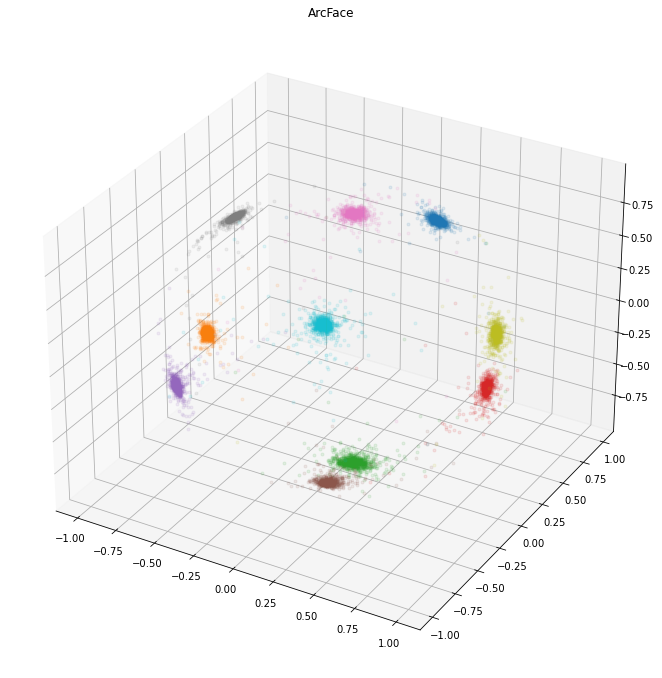

In [48]:

fig2 = plt.figure(figsize=(16, 9))
ax2 = Axes3D(fig2)
for c in range(len(np.unique(y))):
    ax2.plot(arcface_features_n[y==c, 0], arcface_features_n[y==c, 1], arcface_features_n[y==c, 2], '.', alpha=0.1)
    plt.title('ArcFace')



plt.show()

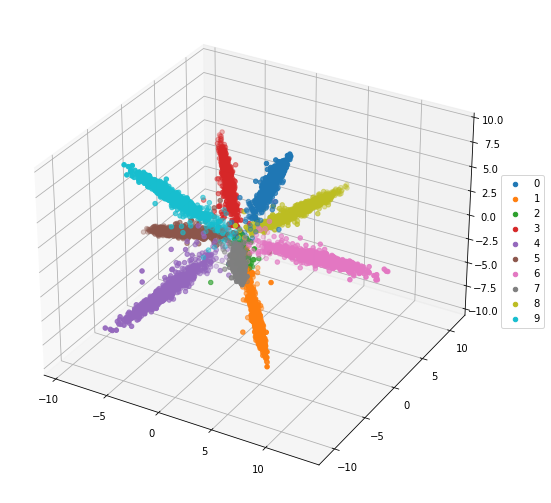

In [49]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')

for i in range(10):
    # Data for three-dimensional scattered points
    xdata = arcface_features[y==i,2].flatten()
    ydata = arcface_features[y==i,0].flatten()
    zdata = arcface_features[y==i,1].flatten()
    ax.scatter3D(xdata, ydata, zdata);
ax.legend(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'],loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [ ]:
PATH='./'
for k, model in models.items():
    torch.save(model.state_dict(), PATH+str(k)+'.mod')

In [ ]:
#model = TheModelClass(*args, **kwargs)
#model.load_state_dict(torch.load(PATH))
#model.eval()